# Appendix

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.feature_extraction import stop_words
from collections import Counter
import re

import nltk
from nltk import bigrams
from nltk import trigrams

import matplotlib.pyplot as plt
import seaborn as sns

# Import Listings

In [3]:
# London listings Feb 2019

listings = pd.read_csv('listings_2019.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [176]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       ...
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month'],
      dtype='object', length=106)

In [174]:
listings[['name','price','neighbourhood_cleansed']].sample(5) 
# (KER1)Comfy ... Remove brackets from start word

,name,price,neighbourhood_cleansed
63097,Modern En-suite Double bedroom near Canary Wharf,$44.00,Tower Hamlets
67612,Delightful apartment right next to Battersea P...,$95.00,Wandsworth
20133,Airy Studio Apartment in Kensington,$120.00,Kensington and Chelsea
71432,Stunning Studio with amazing garden space,$47.00,Hounslow
73475,"Best flat in Central London, next to the Museums",$250.00,Kensington and Chelsea


In [7]:
# Remove Nan names
listings_name_dropna = listings[~listings['name'].isna()]

In [10]:
Counter(list(listings_name_dropna['name'])).most_common(10)

[('★AMAZING★ Ensuite Rooms in Tottenham Hale!', 35),
 ('Double room', 34),
 ('Greater London Apartment', 34),
 ('London Multi-unit building', 24),
 ('Heathrow Airport Apartments (Peymans)', 22),
 ('Double Room', 20),
 ('2 bed/ 2 bathroom apartment, 15 mins to Canary Wharf', 20),
 ('Cosy Room w/ Shared Kitchen in Bethnal Green!', 20),
 ('Single room', 18),
 ('Central London Apartment', 16)]

# Tokenization

In [8]:
# normalize: all lowercase and un-capitalize

import string
length = []
for name in listings_name_dropna['name']:
    test = name.lower().strip().split(' ')
    res = [s.translate(str.maketrans('', '', string.punctuation)) for s in test]
    length.append(len(res))
    
    

In [9]:
# Average length of listing name
sum(length)/len(length)

6.352647760470486

In [10]:
# normalize: all lowercase and un-capitalize

import string
vocab_list = []
for name in listings_name_dropna['name']:
    test = name.lower().strip().split(' ')
    res = [s.translate(str.maketrans('', '', string.punctuation)) for s in test]
    vocab_list += res
    
    

In [11]:
# 'Dirty' vocab dictionary - to use for prioritizing tokenization process
vocab_dict = Counter(vocab_list)

In [12]:
# Create df with relevant columns
listings_df = listings_name_dropna[['name','price','neighbourhood_cleansed','zipcode']]

In [13]:
listings_df.head()

,name,price,neighbourhood_cleansed,zipcode
0,"Cozy, 3 minutes to Piccadilly Line",$35.00,Haringey,N8 0EY
1,Holiday London DB Room Let-on going,$65.00,Islington,N4 3
2,Bright Chelsea Apartment. Chelsea!,$100.00,Kensington and Chelsea,SW3
3,Superb 3-Bed/2 Bath & Wifi: Trendy W1,$300.00,Westminster,W1T4BP
4,Battersea 2 bedroom house & parking,$175.00,Wandsworth,SW11 5GX


In [14]:
# All lower case
listings_df['token_process'] = [name.strip().lower() for name in listings_df['name']]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Abreviation Tokenization

In [15]:
# Tokenize apt/./, to apartment (and Apt)
listings_df['token_process'] = [name.replace(' apt',' apartment') if ' apt' in name else name for name in listings_df['token_process']]
listings_df['token_process'] = [name.replace('apt ','apartment ') if 'apt ' in name else name for name in listings_df['token_process']]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
# Tokenize db to double
listings_df['token_process'] = [name.replace(' db ',' double ') if ' db ' in name else name for name in listings_df['token_process']]
listings_df['token_process'] = [name.replace('db ','double ') if 'db ' in name else name for name in listings_df['token_process']]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
# Tokenize w and w/ to with
listings_df['token_process'] = [name.replace(' w ',' with ') if ' w ' in name else name for name in listings_df['token_process']]
listings_df['token_process'] = [name.replace(' w/ ',' with ') if ' w/ ' in name else name for name in listings_df['token_process']]
listings_df['token_process'] = [name.replace(' w/',' with ') if ' w/' in name else name for name in listings_df['token_process']]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [18]:
# dbl to double
listings_df['token_process'] = [name.replace('dbl','double') if 'dbl' in name else name for name in listings_df['token_process']]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [19]:
# rm to room
listings_df['token_process'] = [name.replace(' rm',' room') if ' rm' in name else name for name in listings_df['token_process']]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [20]:
# nr to near
listings_df['token_process'] = [name.replace(' nr',' near') if ' nr' in name else name for name in listings_df['token_process']]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Amenities Tokenization

In [21]:
# Tokenize en-suite to ensuite (en-suite, En-suite, En-Suite all considered)
listings_df['token_process'] = [name.replace('en-suite','ensuite') if 'en-suite' in name else name for name in listings_df['token_process']]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [22]:
# bedrooms to bedroom
listings_df['token_process'] = [name.replace('bedrooms','bedroom') if 'bedrooms' in name else name for name in listings_df['token_process']]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [23]:
# Tokenize x-y as x to y to avoid errors when removing punctuation 
listings_df['token_process'] = [re.sub(r'(sleeps \d)-(\d+)', r'\1 to \2', str(name)) for name in listings_df['token_process']]

# Same reasoning as above but using / instead of -
listings_df['token_process'] = [re.sub(r'(sleeps \d)/(\d+)', r'\1 to \2', str(name)) for name in listings_df['token_process']]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [24]:
# bathrooms to bathroom
listings_df['token_process'] = [name.replace('bathrooms','bathroom') if 'bathrooms' in name else name for name in listings_df['token_process']]
    

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [25]:
# replace baths with bath
listings_df['token_process'] = [name.replace('baths','bath') if 'baths' in name else name for name in listings_df['token_process']]
    

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [26]:
# replace bath with bathroom
listings_df['token_process'] = [name.replace('bath ','bathroom ') if 'bath ' in name else name for name in listings_df['token_process']]
    

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [27]:
# numberbr to text bedroom
number_list = ['one','two','three','four','five','six','seven','eight','nine','ten','eleven','twelve','thirteen','fourteen','fithteen','sixteen','seventeen','eighteen','nineteen','twenty']
for c,i in enumerate(number_list,1):
    listings_df['token_process'] = [name.replace('%sbr'%c,'%s bedroom'%i) if '%sbr'%c in name else name for name in listings_df['token_process']]
    

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [28]:
# numberbd to text bedroom
number_list = ['one','two','three','four','five','six','seven','eight','nine','ten','eleven','twelve','thirteen','fourteen','fithteen','sixteen','seventeen','eighteen','nineteen','twenty']
for c,i in enumerate(number_list,1):
    listings_df['token_process'] = [name.replace('%sbd'%c,'%s bed'%i) if '%sbd'%c in name else name for name in listings_df['token_process']]
    

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [29]:
# numberbed to text bed
number_list = ['one','two','three','four','five','six','seven','eight','nine','ten','eleven','twelve','thirteen','fourteen','fithteen','sixteen','seventeen','eighteen','nineteen','twenty']
for c,i in enumerate(number_list,1):
    listings_df['token_process'] = [name.replace('%sbed '%c,'%s bed '%i) if '%sbed '%c in name else name for name in listings_df['token_process']]
    

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [30]:
# numberbedroom to text bedroom
number_list = ['one','two','three','four','five','six','seven','eight','nine','ten','eleven','twelve','thirteen','fourteen','fithteen','sixteen','seventeen','eighteen','nineteen','twenty']
for c,i in enumerate(number_list,1):
    listings_df['token_process'] = [name.replace('%sbedroom '%c,'%s bedroom '%i) if '%sbedroom '%c in name else name for name in listings_df['token_process']]
    

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [31]:
# number bed to text bed
number_list = ['one','two','three','four','five','six','seven','eight','nine','ten','eleven','twelve','thirteen','fourteen','fithteen','sixteen','seventeen','eighteen','nineteen','twenty']
for c,i in enumerate(number_list,1):
    listings_df['token_process'] = [name.replace('%s bed'%c,'%s bed'%i) if '%s bed'%c in name else name for name in listings_df['token_process']]
    

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [32]:
# number-bed to text bed
number_list = ['one','two','three','four','five','six','seven','eight','nine','ten','eleven','twelve','thirteen','fourteen','fithteen','sixteen','seventeen','eighteen','nineteen','twenty']
for c,i in enumerate(number_list,1):
    listings_df['token_process'] = [name.replace('%s-bed'%c,'%s bed'%i) if '%s-bed'%c in name else name for name in listings_df['token_process']]
    

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [33]:
# number-bath to text bath
number_list = ['one','two','three','four','five','six','seven','eight','nine','ten','eleven','twelve','thirteen','fourteen','fithteen','sixteen','seventeen','eighteen','nineteen','twenty']
for c,i in enumerate(number_list,1):
    listings_df['token_process'] = [name.replace('%s bath'%c,'%s bath'%i) if '%s bath'%c in name else name for name in listings_df['token_process']]
    

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


## More Tokenization 

Need to order when finished

In [34]:
# All lower case
listings_df['token_process'] = [name.strip().lower() for name in listings_df['token_process']]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [35]:
# 01 to 1
listings_df['token_process'] = [name.replace(' 01 ',' 1 ') if ' 01 ' in name else name for name in listings_df['token_process']]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [36]:
# replace 1st with first
listings_df['token_process'] = [name.replace('1st','first') if '1st' in name else name for name in listings_df['token_process']]
 
# replace 2nd with second
listings_df['token_process'] = [name.replace('2nd','second') if '2nd' in name else name for name in listings_df['token_process']]
    

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


## Punctuation

In [37]:
# replace / with space
listings_df['token_process'] = [re.sub(r'(\S)\/(\S)', r'\1 \2', str(name)) for name in listings_df['token_process']]
    

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [38]:
# replace - with space
listings_df['token_process'] = [re.sub(r'(\S)-(\S)', r'\1 \2', str(name)) for name in listings_df['token_process']]
    

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Location Tokenization

In [39]:
listings_df.head()

,name,price,neighbourhood_cleansed,zipcode,token_process
0,"Cozy, 3 minutes to Piccadilly Line",$35.00,Haringey,N8 0EY,"cozy, 3 minutes to piccadilly line"
1,Holiday London DB Room Let-on going,$65.00,Islington,N4 3,holiday london double room let on going
2,Bright Chelsea Apartment. Chelsea!,$100.00,Kensington and Chelsea,SW3,bright chelsea apartment. chelsea!
3,Superb 3-Bed/2 Bath & Wifi: Trendy W1,$300.00,Westminster,W1T4BP,superb three bed two bathroom & wifi: trendy w1
4,Battersea 2 bedroom house & parking,$175.00,Wandsworth,SW11 5GX,battersea two bedroom house & parking


In [40]:
length = []
for name in listings_df['token_process']:
    test = name.lower().strip().split(' ')
    res = [s.translate(str.maketrans('', '', string.punctuation)) for s in test]
    length.append(len(res))
    
    

In [46]:
# test that token process worked

vocab_list2 = []
for name in listings_df['name_tokenized']:
    test = name.strip().split(' ')
    res = [s.translate(str.maketrans('', '', string.punctuation)) for s in test]
    vocab_list2 += res
    

In [47]:
vocab_dict2 = Counter(vocab_list2)

In [167]:
listings_df[listings_df['token_process']=='britannia russell square 1']

,name,price,neighbourhood_cleansed,zipcode,token_process,unigrams,bigrams,trigrams
31343,Britannia Russell Square 1,$40.00,Camden,WC1N 1DJ,britannia russell square 1,"[britannia, russell, square, 1]","[(britannia, russell), (russell, square), (squ...","[(britannia, russell, square), (russell, squar..."


## Create Unigrams

In [41]:
import string

In [42]:
tokens = []
for name in listings_df['token_process']:
    test = name.strip().split(' ')
    res = [s.translate(str.maketrans('', '', string.punctuation)) for s in test]
    try: 
        res.remove('')
        tokens.append(res)
    except:
        tokens.append(res)
    

In [43]:
listings_df['unigrams'] = tokens

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [44]:
listings_df.head()

,name,price,neighbourhood_cleansed,zipcode,token_process,unigrams
0,"Cozy, 3 minutes to Piccadilly Line",$35.00,Haringey,N8 0EY,"cozy, 3 minutes to piccadilly line","[cozy, 3, minutes, to, piccadilly, line]"
1,Holiday London DB Room Let-on going,$65.00,Islington,N4 3,holiday london double room let on going,"[holiday, london, double, room, let, on, going]"
2,Bright Chelsea Apartment. Chelsea!,$100.00,Kensington and Chelsea,SW3,bright chelsea apartment. chelsea!,"[bright, chelsea, apartment, chelsea]"
3,Superb 3-Bed/2 Bath & Wifi: Trendy W1,$300.00,Westminster,W1T4BP,superb three bed two bathroom & wifi: trendy w1,"[superb, three, bed, two, bathroom, wifi, tren..."
4,Battersea 2 bedroom house & parking,$175.00,Wandsworth,SW11 5GX,battersea two bedroom house & parking,"[battersea, two, bedroom, house, parking]"


## Create Bigrams

In [45]:
listings_df['bigrams'] = [list(bigrams(entry)) for entry in listings_df['unigrams']]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [46]:
listings_df.head()

,name,price,neighbourhood_cleansed,zipcode,token_process,unigrams,bigrams
0,"Cozy, 3 minutes to Piccadilly Line",$35.00,Haringey,N8 0EY,"cozy, 3 minutes to piccadilly line","[cozy, 3, minutes, to, piccadilly, line]","[(cozy, 3), (3, minutes), (minutes, to), (to, ..."
1,Holiday London DB Room Let-on going,$65.00,Islington,N4 3,holiday london double room let on going,"[holiday, london, double, room, let, on, going]","[(holiday, london), (london, double), (double,..."
2,Bright Chelsea Apartment. Chelsea!,$100.00,Kensington and Chelsea,SW3,bright chelsea apartment. chelsea!,"[bright, chelsea, apartment, chelsea]","[(bright, chelsea), (chelsea, apartment), (apa..."
3,Superb 3-Bed/2 Bath & Wifi: Trendy W1,$300.00,Westminster,W1T4BP,superb three bed two bathroom & wifi: trendy w1,"[superb, three, bed, two, bathroom, wifi, tren...","[(superb, three), (three, bed), (bed, two), (t..."
4,Battersea 2 bedroom house & parking,$175.00,Wandsworth,SW11 5GX,battersea two bedroom house & parking,"[battersea, two, bedroom, house, parking]","[(battersea, two), (two, bedroom), (bedroom, h..."


## Create Trigrams

In [47]:
listings_df['trigrams'] = [list(trigrams(entry)) for entry in listings_df['unigrams']]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [48]:
listings_df.head()

,name,price,neighbourhood_cleansed,zipcode,token_process,unigrams,bigrams,trigrams
0,"Cozy, 3 minutes to Piccadilly Line",$35.00,Haringey,N8 0EY,"cozy, 3 minutes to piccadilly line","[cozy, 3, minutes, to, piccadilly, line]","[(cozy, 3), (3, minutes), (minutes, to), (to, ...","[(cozy, 3, minutes), (3, minutes, to), (minute..."
1,Holiday London DB Room Let-on going,$65.00,Islington,N4 3,holiday london double room let on going,"[holiday, london, double, room, let, on, going]","[(holiday, london), (london, double), (double,...","[(holiday, london, double), (london, double, r..."
2,Bright Chelsea Apartment. Chelsea!,$100.00,Kensington and Chelsea,SW3,bright chelsea apartment. chelsea!,"[bright, chelsea, apartment, chelsea]","[(bright, chelsea), (chelsea, apartment), (apa...","[(bright, chelsea, apartment), (chelsea, apart..."
3,Superb 3-Bed/2 Bath & Wifi: Trendy W1,$300.00,Westminster,W1T4BP,superb three bed two bathroom & wifi: trendy w1,"[superb, three, bed, two, bathroom, wifi, tren...","[(superb, three), (three, bed), (bed, two), (t...","[(superb, three, bed), (three, bed, two), (bed..."
4,Battersea 2 bedroom house & parking,$175.00,Wandsworth,SW11 5GX,battersea two bedroom house & parking,"[battersea, two, bedroom, house, parking]","[(battersea, two), (two, bedroom), (bedroom, h...","[(battersea, two, bedroom), (two, bedroom, hou..."


# Random sample to check tokenization

In [49]:
listings_df.sample(5)

,name,price,neighbourhood_cleansed,zipcode,token_process,unigrams,bigrams,trigrams
57674,Homely 1 bedroom ground floor flat with garden,$68.00,Wandsworth,SW18 4QL,homely one bedroom ground floor flat with garden,"[homely, one, bedroom, ground, floor, flat, wi...","[(homely, one), (one, bedroom), (bedroom, grou...","[(homely, one, bedroom), (one, bedroom, ground..."
58890,"1 stop to London Bridge,3 stops Big Ben 1 bed ...",$95.00,Southwark,SE16,"1 stop to london bridge,3 stops big ben one be...","[1, stop, to, london, bridge3, stops, big, ben...","[(1, stop), (stop, to), (to, london), (london,...","[(1, stop, to), (stop, to, london), (to, londo..."
29371,★ Covent Garden - Spacious Apartment ★,$349.00,Westminster,WC2N,★ covent garden - spacious apartment ★,"[★, covent, garden, spacious, apartment, ★]","[(★, covent), (covent, garden), (garden, spaci...","[(★, covent, garden), (covent, garden, spaciou..."
13455,Double room with private bathroom - Brockley z...,$35.00,Lewisham,SE1 9AH,double room with private bathroom - brockley z...,"[double, room, with, private, bathroom, brockl...","[(double, room), (room, with), (with, private)...","[(double, room, with), (room, with, private), ..."
39104,Spacious Double room in ideal London location,$34.00,Islington,N4 3LD,spacious double room in ideal london location,"[spacious, double, room, in, ideal, london, lo...","[(spacious, double), (double, room), (room, in...","[(spacious, double, room), (double, room, in),..."


## Format price

In [50]:
listings_df2 = listings_df.copy(deep=True)

In [51]:
# Remove dollar sign
listings_df2['price'] = [price.replace('$','') for price in listings_df2['price']]

In [52]:
# Remove commas
listings_df2['price'] = [price.replace(',','') for price in listings_df2['price']]

In [53]:
# Convert to float
listings_df2['price'] = [float(price) for price in listings_df2['price']]

In [54]:
# remove 29 properties with 0 price
listings_df2 = listings_df2[listings_df2['price']>0]

In [55]:
listings_df2.sample(10)

,name,price,neighbourhood_cleansed,zipcode,token_process,unigrams,bigrams,trigrams
75693,Single bedroom close to Buckingham Palace,34.0,Westminster,SW1V 3DW,single bedroom close to buckingham palace,"[single, bedroom, close, to, buckingham, palace]","[(single, bedroom), (bedroom, close), (close, ...","[(single, bedroom, close), (bedroom, close, to..."
67806,Covent Garden Pearl,200.0,Westminster,WC2E 7NU,covent garden pearl,"[covent, garden, pearl]","[(covent, garden), (garden, pearl)]","[(covent, garden, pearl)]"
29582,Huge room in regency property by river in Chis...,58.0,Hounslow,W4 3RU,huge room in regency property by river in chis...,"[huge, room, in, regency, property, by, river,...","[(huge, room), (room, in), (in, regency), (reg...","[(huge, room, in), (room, in, regency), (in, r..."
20944,Studio aux abords de Hyde park,80.0,Westminster,W2,studio aux abords de hyde park,"[studio, aux, abords, de, hyde, park]","[(studio, aux), (aux, abords), (abords, de), (...","[(studio, aux, abords), (aux, abords, de), (ab..."
34614,Charming 2-Bedroom Flat with Roof Terrace - Ca...,120.0,Camden,NW5,charming two bedroom flat with roof terrace - ...,"[charming, two, bedroom, flat, with, roof, ter...","[(charming, two), (two, bedroom), (bedroom, fl...","[(charming, two, bedroom), (two, bedroom, flat..."
39835,Spacious 3 bedroom Victorian home Nunhead/Peckham,220.0,Southwark,SE15 2BS,spacious three bedroom victorian home nunhead ...,"[spacious, three, bedroom, victorian, home, nu...","[(spacious, three), (three, bedroom), (bedroom...","[(spacious, three, bedroom), (three, bedroom, ..."
34803,"Large quiet double room in loft, own bathroom",27.0,Barnet,NW4 1NP,"large quiet double room in loft, own bathroom","[large, quiet, double, room, in, loft, own, , ...","[(large, quiet), (quiet, double), (double, roo...","[(large, quiet, double), (quiet, double, room)..."
25551,Lovely garden flat in leafy Parsons Green,85.0,Hammersmith and Fulham,SW6,lovely garden flat in leafy parsons green,"[lovely, garden, flat, in, leafy, parsons, green]","[(lovely, garden), (garden, flat), (flat, in),...","[(lovely, garden, flat), (garden, flat, in), (..."
57541,Comfortable single room very near centre of Lo...,27.0,Hammersmith and Fulham,W6 0TB,comfortable single room very near centre of lo...,"[comfortable, single, room, very, near, centre...","[(comfortable, single), (single, room), (room,...","[(comfortable, single, room), (single, room, v..."
57558,Beautiful 2Bed/2Bath apt sleeps 6 in Farringdon,180.0,Camden,EC1M 3HA,beautiful 2bed 2bathroom apartment sleeps 6 in...,"[beautiful, 2bed, 2bathroom, apartment, sleeps...","[(beautiful, 2bed), (2bed, 2bathroom), (2bathr...","[(beautiful, 2bed, 2bathroom), (2bed, 2bathroo..."


In [56]:
listings_df2.head()

,name,price,neighbourhood_cleansed,zipcode,token_process,unigrams,bigrams,trigrams
0,"Cozy, 3 minutes to Piccadilly Line",35.0,Haringey,N8 0EY,"cozy, 3 minutes to piccadilly line","[cozy, 3, minutes, to, piccadilly, line]","[(cozy, 3), (3, minutes), (minutes, to), (to, ...","[(cozy, 3, minutes), (3, minutes, to), (minute..."
1,Holiday London DB Room Let-on going,65.0,Islington,N4 3,holiday london double room let on going,"[holiday, london, double, room, let, on, going]","[(holiday, london), (london, double), (double,...","[(holiday, london, double), (london, double, r..."
2,Bright Chelsea Apartment. Chelsea!,100.0,Kensington and Chelsea,SW3,bright chelsea apartment. chelsea!,"[bright, chelsea, apartment, chelsea]","[(bright, chelsea), (chelsea, apartment), (apa...","[(bright, chelsea, apartment), (chelsea, apart..."
3,Superb 3-Bed/2 Bath & Wifi: Trendy W1,300.0,Westminster,W1T4BP,superb three bed two bathroom & wifi: trendy w1,"[superb, three, bed, two, bathroom, wifi, tren...","[(superb, three), (three, bed), (bed, two), (t...","[(superb, three, bed), (three, bed, two), (bed..."
4,Battersea 2 bedroom house & parking,175.0,Wandsworth,SW11 5GX,battersea two bedroom house & parking,"[battersea, two, bedroom, house, parking]","[(battersea, two), (two, bedroom), (bedroom, h...","[(battersea, two, bedroom), (two, bedroom, hou..."


In [57]:
bins = list(range(10,501,10))

(array([ 773., 5421., 8310., 7398., 6290., 5127., 4889., 4746., 4875.,
        3967., 2512., 3624., 1997., 1845., 2753., 1345., 1160., 1134.,
        1004., 1370.,  365.,  723.,  324.,  388.,  973.,  217.,  244.,
         274.,  301.,  574.,   75.,  208.,  102.,  138.,  383.,   79.,
          83.,   84.,  163.,  230.,   30.,   83.,   46.,   50.,  155.,
          24.,   32.,   34.,  299.]),
 array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
        140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260,
        270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390,
        400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500]),
 <a list of 49 Patch objects>)

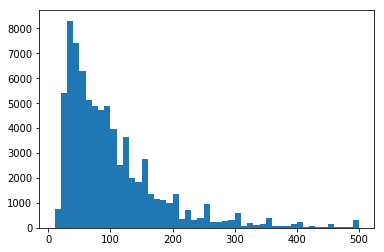

In [58]:
plt.hist(listings_df2['price'],bins = bins)

In [59]:
len(listings_df2[listings_df2['price']>200])

7977

# Naive Bayes

## Data formatting

In [61]:
# Data formatting
listings_df2['price'].quantile(q=0.75)

130.0

In [118]:
# say we use 4 bins of quartile
# 1 = x< 45, 2 = 45>= x <=80, 3 = 80<=x<130, 4 = x>=130

listings_df2['bins'] = [1 if price < 45 else 2 if price >= 45 and price <80 else 3 if price >= 80 and price <130 else 4 for price in listings_df2['price']]

In [119]:
listings_df2.head()

,name,price,neighbourhood_cleansed,zipcode,token_process,unigrams,bigrams,trigrams,bins
0,"Cozy, 3 minutes to Piccadilly Line",35.0,Haringey,N8 0EY,"cozy, 3 minutes to piccadilly line","[cozy, 3, minutes, to, piccadilly, line]","[(cozy, 3), (3, minutes), (minutes, to), (to, ...","[(cozy, 3, minutes), (3, minutes, to), (minute...",1
1,Holiday London DB Room Let-on going,65.0,Islington,N4 3,holiday london double room let on going,"[holiday, london, double, room, let, on, going]","[(holiday, london), (london, double), (double,...","[(holiday, london, double), (london, double, r...",2
2,Bright Chelsea Apartment. Chelsea!,100.0,Kensington and Chelsea,SW3,bright chelsea apartment. chelsea!,"[bright, chelsea, apartment, chelsea]","[(bright, chelsea), (chelsea, apartment), (apa...","[(bright, chelsea, apartment), (chelsea, apart...",3
3,Superb 3-Bed/2 Bath & Wifi: Trendy W1,300.0,Westminster,W1T4BP,superb three bed two bathroom & wifi: trendy w1,"[superb, three, bed, two, bathroom, wifi, tren...","[(superb, three), (three, bed), (bed, two), (t...","[(superb, three, bed), (three, bed, two), (bed...",4
4,Battersea 2 bedroom house & parking,175.0,Wandsworth,SW11 5GX,battersea two bedroom house & parking,"[battersea, two, bedroom, house, parking]","[(battersea, two), (two, bedroom), (bedroom, h...","[(battersea, two, bedroom), (two, bedroom, hou...",4


In [120]:
listings_df2['unigrams_labelled'] = list(zip(listings_df2['unigrams'], listings_df2['bins']))

In [121]:
listings_df2['bigrams_labelled'] = list(zip(listings_df2['bigrams'], listings_df2['bins']))

In [122]:
listings_df2['trigrams_labelled'] = list(zip(listings_df2['trigrams'], listings_df2['bins']))

In [123]:
listings_df2.head()

,name,price,neighbourhood_cleansed,zipcode,token_process,unigrams,bigrams,trigrams,bins,unigrams_labelled,bigrams_labelled,trigrams_labelled
0,"Cozy, 3 minutes to Piccadilly Line",35.0,Haringey,N8 0EY,"cozy, 3 minutes to piccadilly line","[cozy, 3, minutes, to, piccadilly, line]","[(cozy, 3), (3, minutes), (minutes, to), (to, ...","[(cozy, 3, minutes), (3, minutes, to), (minute...",1,"([cozy, 3, minutes, to, piccadilly, line], 1)","([(cozy, 3), (3, minutes), (minutes, to), (to,...","([(cozy, 3, minutes), (3, minutes, to), (minut..."
1,Holiday London DB Room Let-on going,65.0,Islington,N4 3,holiday london double room let on going,"[holiday, london, double, room, let, on, going]","[(holiday, london), (london, double), (double,...","[(holiday, london, double), (london, double, r...",2,"([holiday, london, double, room, let, on, goin...","([(holiday, london), (london, double), (double...","([(holiday, london, double), (london, double, ..."
2,Bright Chelsea Apartment. Chelsea!,100.0,Kensington and Chelsea,SW3,bright chelsea apartment. chelsea!,"[bright, chelsea, apartment, chelsea]","[(bright, chelsea), (chelsea, apartment), (apa...","[(bright, chelsea, apartment), (chelsea, apart...",3,"([bright, chelsea, apartment, chelsea], 3)","([(bright, chelsea), (chelsea, apartment), (ap...","([(bright, chelsea, apartment), (chelsea, apar..."
3,Superb 3-Bed/2 Bath & Wifi: Trendy W1,300.0,Westminster,W1T4BP,superb three bed two bathroom & wifi: trendy w1,"[superb, three, bed, two, bathroom, wifi, tren...","[(superb, three), (three, bed), (bed, two), (t...","[(superb, three, bed), (three, bed, two), (bed...",4,"([superb, three, bed, two, bathroom, wifi, tre...","([(superb, three), (three, bed), (bed, two), (...","([(superb, three, bed), (three, bed, two), (be..."
4,Battersea 2 bedroom house & parking,175.0,Wandsworth,SW11 5GX,battersea two bedroom house & parking,"[battersea, two, bedroom, house, parking]","[(battersea, two), (two, bedroom), (bedroom, h...","[(battersea, two, bedroom), (two, bedroom, hou...",4,"([battersea, two, bedroom, house, parking], 4)","([(battersea, two), (two, bedroom), (bedroom, ...","([(battersea, two, bedroom), (two, bedroom, ho..."


In [124]:
# split data into train and test

msk = np.random.rand(len(listings_df2)) < 0.8

train = listings_df2[msk]

test = listings_df2[~msk]

In [125]:
print(len(train),len(test))

62659 15699


## Ngrams Vocab and Counts

In [131]:
# Create unigarm vocab and count
unigram_vocab_train = [word for name in train['unigrams'] for word in name]
unigram_vocab_test = [word for name in test['unigrams'] for word in name]

unigram_counter_train = Counter(unigram_vocab_train)
unigram_counter_test = Counter(unigram_vocab_test)

In [132]:
print(unigram_counter_train.most_common(10))
print(unigram_counter_test.most_common(10))

[('in', 22590), ('room', 15182), ('flat', 13279), ('london', 11850), ('bedroom', 11737), ('double', 10367), ('apartment', 9608), ('bed', 8810), ('two', 7591), ('with', 6817)]
[('in', 5790), ('room', 3951), ('flat', 3215), ('london', 2983), ('bedroom', 2826), ('double', 2591), ('apartment', 2464), ('bed', 2268), ('two', 1868), ('with', 1642)]


In [133]:
# Create bigarm vocab and count
bigram_vocab_train = [word for name in train['bigrams'] for word in name]
bigram_vocab_test = [word for name in test['bigrams'] for word in name]

bigram_counter_train = Counter(bigram_vocab_train)
bigram_counter_test = Counter(bigram_vocab_test)

In [134]:
print(bigram_counter_train.most_common(10))
print(bigram_counter_test.most_common(10))

[(('room', 'in'), 6058), (('double', 'room'), 5871), (('flat', 'in'), 4335), (('two', 'bed'), 3372), (('central', 'london'), 3295), (('two', 'bedroom'), 3132), (('one', 'bedroom'), 2955), (('one', 'bed'), 2593), (('double', 'bedroom'), 2492), (('apartment', 'in'), 2430)]
[(('room', 'in'), 1651), (('double', 'room'), 1518), (('flat', 'in'), 1083), (('two', 'bed'), 859), (('central', 'london'), 824), (('two', 'bedroom'), 736), (('one', 'bedroom'), 721), (('one', 'bed'), 698), (('apartment', 'in'), 611), (('double', 'bedroom'), 600)]


In [135]:
# Create trigarm vocab and count
trigram_vocab_train = [word for name in train['trigrams'] for word in name]
trigram_vocab_test = [word for name in test['trigrams'] for word in name]

trigram_counter_train = Counter(trigram_vocab_train)
trigram_counter_test = Counter(trigram_vocab_test)

In [136]:
print(trigram_counter_train.most_common(10))
print(trigram_counter_test.most_common(10))

[(('double', 'room', 'in'), 2503), (('the', 'heart', 'of'), 1214), (('in', 'the', 'heart'), 1168), (('one', 'bedroom', 'flat'), 1149), (('in', 'central', 'london'), 1070), (('one', 'bed', 'flat'), 985), (('bedroom', 'flat', 'in'), 980), (('two', 'bedroom', 'flat'), 928), (('double', 'bedroom', 'in'), 916), (('one', 'bedroom', 'apartment'), 842)]
[(('double', 'room', 'in'), 682), (('the', 'heart', 'of'), 293), (('in', 'central', 'london'), 290), (('in', 'the', 'heart'), 280), (('one', 'bedroom', 'flat'), 267), (('double', 'bedroom', 'in'), 254), (('one', 'bed', 'flat'), 251), (('two', 'bed', 'flat'), 229), (('one', 'bedroom', 'apartment'), 218), (('two', 'bedroom', 'apartment'), 214)]


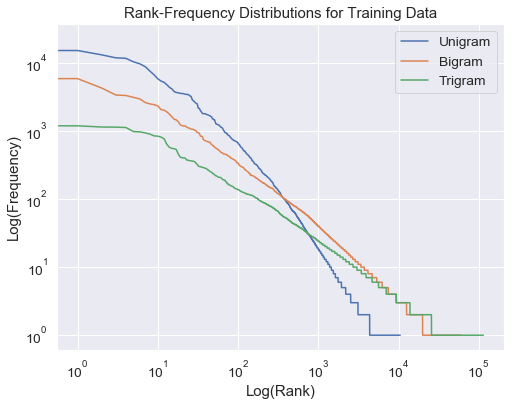

In [176]:
sns.set(font_scale=1.25)
plt.figure(figsize=(8,6))
plt.loglog(range(len(unigram_counter_train)), sorted(unigram_counter_train.values(), reverse=True), label='Unigram')
plt.loglog(range(len(bigram_counter_train)), sorted(bigram_counter_train.values(), reverse=True), label='Bigram')
plt.loglog(range(len(trigram_counter_train)), sorted(trigram_counter_train.values(), reverse=True), label='Trigram')
plt.title('Rank-Frequency Distributions for Training Data')
plt.xlabel('Log(Rank)')
plt.ylabel('Log(Frequency)')
plt.legend()
plt.show()

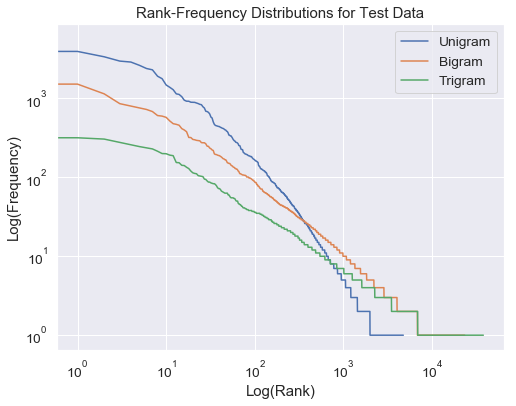

In [177]:
sns.set(font_scale=1.25)
plt.figure(figsize=(8,6))
plt.loglog(range(len(unigram_counter_test)), sorted(unigram_counter_test.values(), reverse=True), label='Unigram')
plt.loglog(range(len(bigram_counter_test)), sorted(bigram_counter_test.values(), reverse=True), label='Bigram')
plt.loglog(range(len(trigram_counter_test)), sorted(trigram_counter_test.values(), reverse=True), label='Trigram')
plt.title('Rank-Frequency Distributions for Test Data')
plt.xlabel('Log(Rank)')
plt.ylabel('Log(Frequency)')
plt.legend()
plt.show()

In [179]:
# How much do vocabularies overlap?

unigram_vocab = [set(unigram_vocab_train), set(unigram_vocab_test)]
unigram_vocab_array = np.empty([len(unigram_vocab),len(unigram_vocab)])

for i in range(len(unigram_vocab)):
    for j in range(len(unigram_vocab)):
        unigram_vocab_array[i][j] = len(unigram_vocab[i].intersection(unigram_vocab[j]))

unigram_vocab_df = pd.DataFrame(unigram_vocab_array.astype(int), columns=['UNIGRAM TRAINING', 'UNIGRAM TEST'])
unigram_vocab_df.rename(index={0: 'UNIGRAM TRAINING', 1: 'UNIGRAM TEST'}, inplace=True)
unigram_vocab_df

,UNIGRAM TRAINING,UNIGRAM TEST
UNIGRAM TRAINING,10504,3224
UNIGRAM TEST,3224,4744


In [126]:
# Format ngrams for NLTK classifier

# Unigrams
unigram_training_set = [(dict(Counter(unigram)), price) for (unigram, price) in train['unigrams_labelled']]
unigram_test_set = [(dict(Counter(unigram)), price) for (unigram, price) in test['unigrams_labelled']]

# Bigrams
bigram_training_set = [(dict(Counter(unigram)), price) for (unigram, price) in train['bigrams_labelled']]
bigram_test_set = [(dict(Counter(unigram)), price) for (unigram, price) in test['bigrams_labelled']]

# Trigrams
trigram_training_set = [(dict(Counter(unigram)), price) for (unigram, price) in train['trigrams_labelled']]
trigram_test_set = [(dict(Counter(unigram)), price) for (unigram, price) in test['trigrams_labelled']]

In [127]:
unigram_training_set[0]

({'cozy': 1, '3': 1, 'minutes': 1, 'to': 1, 'piccadilly': 1, 'line': 1}, 1)

In [137]:
# find OOV items

# Unigram
unigram_OOV = list(set(unigram_vocab_test) - set(unigram_vocab_train).intersection(set(unigram_vocab_test)))

# Bigram
bigram_OOV = list(set(bigram_vocab_test) - set(bigram_vocab_train).intersection(set(bigram_vocab_test)))

# Trigram
trigram_OOV = list(set(trigram_vocab_test) - set(trigram_vocab_train).intersection(set(trigram_vocab_test)))

In [138]:
print(len(unigram_OOV),len(bigram_OOV),len(trigram_OOV))

1522 9537 21353


In [188]:
print(len(unigram_OOV)/len(unigram_vocab_test),len(bigram_OOV)/len(bigram_vocab_test),len(trigram_OOV)/len(trigram_vocab_test))



0.015303249678249678 0.11386510978186898 0.3133465404651845


In [171]:
unigram_training_set[0]

({'cozy': 1, '3': 1, 'minutes': 1, 'to': 1, 'piccadilly': 1, 'line': 1}, 1)

# NLTK Classifiers

### Qunatile bins - Remove abbrevations

In [140]:
nltk_unigram_classifier = nltk.NaiveBayesClassifier.train(unigram_training_set)
print(nltk.classify.accuracy(nltk_unigram_classifier, unigram_test_set))
nltk_unigram_classifier.show_most_informative_features(100)

0.5500987324033378
Most Informative Features
                     two = 2                   4 : 1      =    220.8 : 1.0
                 mayfair = 1                   4 : 1      =    123.2 : 1.0
                  female = 1                   1 : 4      =     83.7 : 1.0
               2bathroom = 1                   4 : 2      =     44.4 : 1.0
                   share = 1                   1 : 4      =     42.2 : 1.0
                 managed = 1                   4 : 2      =     40.6 : 1.0
                 harrods = 1                   4 : 1      =     39.5 : 1.0
                  sloane = 1                   4 : 1      =     38.3 : 1.0
                     six = 1                   4 : 2      =     38.0 : 1.0
                   veeve = 1                   4 : 3      =     36.9 : 1.0
                  single = 1                   1 : 4      =     36.7 : 1.0
           knightsbridge = 1                   4 : 2      =     34.3 : 1.0
                   still = 1                   3 : 2   

In [141]:
nltk_bigram_classifier = nltk.NaiveBayesClassifier.train(bigram_training_set)
print(nltk.classify.accuracy(nltk_bigram_classifier, bigram_test_set))
nltk_bigram_classifier.show_most_informative_features(100)

0.54825148098605
Most Informative Features
    ('bright', 'double') = 1                   1 : 4      =    196.6 : 1.0
     ('two', 'bathroom') = 1                   4 : 1      =    171.2 : 1.0
      ('cosy', 'double') = 1                   1 : 4      =    141.9 : 1.0
      ('bright', 'room') = 1                   1 : 4      =    112.5 : 1.0
('bedroom', 'apartment') = 1                   4 : 1      =     89.1 : 1.0
   ('private', 'double') = 1                   1 : 4      =     84.8 : 1.0
        ('double', 'in') = 1                   1 : 4      =     84.5 : 1.0
         ('sleeps', '4') = 1                   3 : 1      =     83.2 : 1.0
           ('20', 'off') = 1                   4 : 1      =     79.0 : 1.0
       ('large', 'room') = 1                   1 : 4      =     75.5 : 1.0
       ('luxury', 'two') = 1                   4 : 1      =     68.5 : 1.0
     ('stunning', 'two') = 1                   4 : 1      =     68.4 : 1.0
        ('cosy', 'room') = 1                   1 : 4     

In [142]:
nltk_trigram_classifier = nltk.NaiveBayesClassifier.train(trigram_training_set)
print(nltk.classify.accuracy(nltk_unigram_classifier, trigram_test_set))
nltk_trigram_classifier.show_most_informative_features(100)

0.2625644945537932
Most Informative Features
('bedroom', 'apartment', 'in') = 1                   4 : 1      =    179.2 : 1.0
('one', 'bedroom', 'apartment') = 1                   3 : 1      =    159.0 : 1.0
('one', 'bed', 'apartment') = 1                   3 : 1      =    101.8 : 1.0
  ('room', 'in', 'east') = 1                   1 : 4      =     85.2 : 1.0
('three', 'bedroom', 'apartment') = 1                   4 : 1      =     82.2 : 1.0
('bed', 'apartment', 'in') = 1                   3 : 1      =     73.3 : 1.0
('two', 'bedroom', 'apartment') = 1                   4 : 1      =     69.7 : 1.0
  ('cosy', 'room', 'in') = 1                   1 : 4      =     68.8 : 1.0
('spacious', 'room', 'in') = 1                   1 : 4      =     65.3 : 1.0
('lovely', 'room', 'in') = 1                   1 : 4      =     63.1 : 1.0
('private', 'double', 'room') = 1                   1 : 4      =     57.8 : 1.0
('luxury', 'two', 'bedroom') = 1                   4 : 1      =     56.3 : 1.0
('luxury',

# Benchmark model based on location

This model will predict the price of the listing to be the average of the area where the listing is located

In [144]:
# drop lisitngs with empty postcodes 1982 are null
# len(listings_df2[listings_df2['zipcode'].isnull()==True])

listings_df3 = listings_df2[listings_df2['zipcode'].isnull()==False]

# # Format postcode column to just districts
listings_df3['zipcode'] = listings_df3['zipcode'].apply(lambda x: (x.split(' ')[0]))
listings_df3['zipcode'] = listings_df3['zipcode'].apply(lambda x: x[:-3] if len(x)>4 else x)
listings_df3['zipcode'] = listings_df3['zipcode'].apply(lambda x: x.lower())

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#index

In [145]:
# split data into train and test

msk = np.random.rand(len(listings_df3)) < 0.8

train_BM = listings_df3[msk]

test_BM = listings_df3[~msk]

In [146]:
mean_price = train_BM.groupby('neighbourhood_cleansed').mean()

In [147]:
mean_price.head()

,price,bins
neighbourhood_cleansed,,
Barking and Dagenham,64.465347,1.841584
Barnet,81.215651,2.046406
Bexley,54.121053,1.642105
Brent,84.353276,2.171510
Bromley,59.200426,1.810235


In [148]:
# assign bin to mean price
# say we use 4 bins of quantile
# 1 = x< 45, 2 = 45<=x<80, 3 = 80<=x<130, 4 = x>=130

bin_ = []
for price in mean_price['price']:
    if price < 45:
        bin_.append(1)
    elif price >= 45 and price <80:
        bin_.append(2)
    elif price >=80 and price < 130:
        bin_.append(3)
    elif price >=130:
        bin_.append(4)
        

In [149]:
mean_price['bin'] = bin_

In [150]:
# Now predict bin for test data, and compare to actual bin
# if district in test not in train, append average price's bin
# 34 listings in test not in train

bin_prediction = []
for listing in test_BM['neighbourhood_cleansed']:
    if listing in list(mean_price.index):
        bin_p = mean_price[mean_price.index == listing]['bin']
        bin_prediction.append(bin_p[0])
    else:
        bin_prediction.append(3)


In [151]:
len(bin_prediction)

15297

In [152]:
len(test_BM)

15297

In [153]:
test_BM['bin_prediction'] = bin_prediction

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [154]:
test_BM.head()

,name,price,neighbourhood_cleansed,zipcode,token_process,unigrams,bigrams,trigrams,bins,unigrams_labelled,bigrams_labelled,trigrams_labelled,bin_prediction
5,All-comforts 2-bed flat near Wimbledon tennis,65.0,Wandsworth,sw19,all comforts two bed flat near wimbledon tennis,"[all, comforts, two, bed, flat, near, wimbledo...","[(all, comforts), (comforts, two), (two, bed),...","[(all, comforts, two), (comforts, two, bed), (...",2,"([all, comforts, two, bed, flat, near, wimbled...","([(all, comforts), (comforts, two), (two, bed)...","([(all, comforts, two), (comforts, two, bed), ...",3
7,FREE WIFI!! Angel Bright Ap Private Terrace by...,147.0,Islington,n1,free wifi!! angel bright ap private terrace by...,"[free, wifi, angel, bright, ap, private, terra...","[(free, wifi), (wifi, angel), (angel, bright),...","[(free, wifi, angel), (wifi, angel, bright), (...",4,"([free, wifi, angel, bright, ap, private, terr...","([(free, wifi), (wifi, angel), (angel, bright)...","([(free, wifi, angel), (wifi, angel, bright), ...",3
14,You are GUARANTEED to love this,72.0,Haringey,n2,you are guaranteed to love this,"[you, are, guaranteed, to, love, this]","[(you, are), (are, guaranteed), (guaranteed, t...","[(you, are, guaranteed), (are, guaranteed, to)...",2,"([you, are, guaranteed, to, love, this], 2)","([(you, are), (are, guaranteed), (guaranteed, ...","([(you, are, guaranteed), (are, guaranteed, to...",2
15,Gorgeous Victorian Flat Overlooking London Fields,80.0,Hackney,e8,gorgeous victorian flat overlooking london fields,"[gorgeous, victorian, flat, overlooking, londo...","[(gorgeous, victorian), (victorian, flat), (fl...","[(gorgeous, victorian, flat), (victorian, flat...",3,"([gorgeous, victorian, flat, overlooking, lond...","([(gorgeous, victorian), (victorian, flat), (f...","([(gorgeous, victorian, flat), (victorian, fla...",3
17,Double room/ lounge,65.0,Croydon,se19,double room/ lounge,"[double, room, lounge]","[(double, room), (room, lounge)]","[(double, room, lounge)]",2,"([double, room, lounge], 2)","([(double, room), (room, lounge)], 2)","([(double, room, lounge)], 2)",2


In [155]:
# Benchmark accuarcy

BM_accuarcy = len(test_BM[test_BM['bins']==test_BM['bin_prediction']])/len(test_BM)

In [156]:
print(BM_accuarcy)

0.32169706478394455


# Lasso Linear Regression

## Unigram Only

In [276]:
unigram_vocab_lasso = set(unigram_vocab_train)
bigram_vocab_lasso = set(bigram_vocab_train)
trigram_vocab_lasso = set(trigram_vocab_train)

In [278]:
print(len(unigram_vocab_lasso),len(bigram_vocab_lasso),len(trigram_vocab_lasso))

10783 61513 117150


In [60]:
# Create unigram one-hot-encoded df
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

lasso_unigram = pd.DataFrame(mlb.fit_transform(listings_df2['unigrams']),columns=mlb.classes_, index=listings_df2.index)
lasso_unigram.head()

,,0,001,003,006,0077,008,01,01022,0110,...,아파트,엄청,욕실,편리한,하나롯지,하우스,화장실,️,️️️️️,ﾛﾝﾄﾞﾝ市内西部､ｾﾝﾄﾗﾙ線ｼｪﾊﾟｰｽﾞ･ﾌﾞｯｼｭ駅より徒歩2分のﾌﾗﾝｽ人と暮らす小さな家
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
lasso_unigram['log_price'] = [np.log(price) for price in listings_df2['price']]

In [119]:
len(lasso_unigram)

78358

In [99]:
# pickle the lasso_df
import pickle 

filename = 'lasso_unigram_df'
outfile = open(filename,'wb')
pickle.dump(lasso_unigram.iloc[:100,:],outfile,protocol=4)
outfile.close()

In [120]:
# Split into train and test data
from sklearn.model_selection import train_test_split

x = lasso_unigram.drop('log_price',1)
y = lasso_unigram[['log_price']]

# test_size: what proportion of original data is used for test set
X_train_unigram_df, X_test_unigram_df, Y_train_unigram_df, Y_test_unigram_df = train_test_split( x, y, test_size=0.2, random_state=0)


In [121]:
len(X_train_unigram_df.columns)

12024

In [122]:
lasso_unigram['log_price'].describe()

count    78358.000000
mean         4.390000
std          0.766271
min          1.791759
25%          3.806662
50%          4.382027
75%          4.867534
max          9.852194
Name: log_price, dtype: float64

In [123]:
from sklearn import linear_model

clf = linear_model.LassoCV(n_alphas = 10)
model_results = clf.fit(X_train_unigram_df,Y_train_unigram_df)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [124]:
import math
import sklearn
y_predict = model_results.predict(X_test_unigram_df)
accuracy = clf.score(X_test_unigram_df,Y_test_unigram_df)
RMSE = math.sqrt(sklearn.metrics.mean_squared_error(Y_test_unigram_df, y_predict))
MAE = (sklearn.metrics.mean_absolute_error(Y_test_unigram_df, y_predict))

In [125]:
accuracy = clf.score(X_test_unigram_df,Y_test_unigram_df)
accuracy

0.5084495893838203

In [126]:
# all variables LassoCV
print(MAE,RMSE)

0.39370031330697486 0.5322513998882134


In [127]:
# Get the coefficients of the model
unigram_coef =clf.coef_

In [128]:
max(np.argsort(a))

NameError: name 'a' is not defined

In [247]:
len(lasso_unigram.columns)

12337

In [129]:
# least informative 20

least_idx_unigram = np.argsort(unigram_coef)[:100]
most_idx_unigram = np.argsort(unigram_coef)[-100:]

In [130]:
# get the least informative parameters

least_parameter_unigram = []
for idx in least_idx_unigram:
    least_parameter_unigram.append(list(X_train_unigram_df.columns)[idx])

In [131]:
# get the most informative parameters

most_parameter_unigram = []
for idx in most_idx_unigram:
    most_parameter_unigram.append(list(X_train_unigram_df.columns)[idx])

In [132]:
least_parameter_unigram

['dorm',
 'dormitory',
 'britannia',
 'room',
 'share',
 'single',
 'doubleroom',
 'greater',
 'small',
 'croydon',
 'friendly',
 'chambre',
 'bedroom',
 'cheap',
 'line',
 'streatham',
 'only',
 'heathrow',
 'dprivate',
 'shared',
 'mile',
 'walthamstow',
 'bed',
 'netflix',
 'away',
 'orpington',
 'female',
 'double',
 'bprivate',
 'welcoming',
 'accommodation',
 'crystal',
 'affordable',
 'good',
 'feel',
 'kingston',
 'guest',
 'budget',
 'cprivate',
 'tv',
 '20min',
 'bedsit',
 'student',
 'stratford',
 'cosy',
 'homely',
 'transport',
 'comfy',
 'tooting',
 'peaceful',
 'mins',
 'clean',
 'norwood',
 'peckham',
 'quiet',
 'rooms',
 'comfortable',
 'sweet',
 'value',
 'studio',
 'welcome',
 'enfield',
 'fast',
 'space',
 'east',
 'cute',
 'master',
 'hostel',
 'short',
 'greenwich',
 'min',
 'hackney',
 'easy',
 'north',
 'for',
 'size',
 'nice',
 'sharing',
 'to',
 'aprivate',
 'cozy',
 'private',
 'sunny',
 'beds',
 'from',
 'a',
 'zone',
 'creative',
 'term',
 'links',
 'clapto

In [133]:
most_parameter_unigram

['3bed',
 'contemporary',
 'vauxhall',
 'moments',
 'waterloo',
 'ac',
 'ben',
 'oxford',
 'w1',
 'off',
 'designer',
 '8',
 'paddington',
 'pool',
 'home',
 'st',
 'regents',
 'house',
 'classic',
 'pimlico',
 'clerkenwell',
 'chiswick',
 'executive',
 '2bathroom',
 'lift',
 'air',
 'apartment',
 'stunning',
 'residence',
 'eye',
 'elegant',
 'court',
 'families',
 'duplex',
 'westminster',
 'concept',
 'rugby',
 'serviced',
 'flexible',
 'luxe',
 'one',
 '2bed',
 'up',
 'grand',
 'notting',
 'standard',
 'br',
 'crawford',
 'holland',
 'family',
 'ken',
 'luxury',
 'tennis',
 'chelsea',
 '2b',
 'street',
 'goodge',
 'kensington',
 'designed',
 'fitzrovia',
 'hyde',
 'gardens',
 'museum',
 'selfridges',
 'luxurious',
 'piccadilly',
 'deluxe',
 'marylebone',
 'merino',
 'apartments',
 'primrose',
 'harrods',
 'square',
 'arch',
 'townhouse',
 'mews',
 'soho',
 'penthouse',
 'iii',
 'eccleston',
 'hotel',
 'buckingham',
 'two',
 'olympics',
 'iv',
 'ii',
 'covent',
 'veeve',
 'sonder',


In [134]:
# Get the coefficients of the parameters

least_unigram_coefficients = []
for idx in least_idx_unigram:
    least_unigram_coefficients.append(unigram_coef[idx])
    
most_unigram_coefficients = []
for idx in most_idx_unigram:
    most_unigram_coefficients.append(unigram_coef[idx])

In [135]:
least_unigram_coefficients

[-1.0821678043977427,
 -0.5743256291309604,
 -0.5457225897918253,
 -0.49896078641905417,
 -0.44141077872958645,
 -0.35404485494048904,
 -0.3415673307440252,
 -0.30918551346398226,
 -0.28087407011444726,
 -0.2807809999178684,
 -0.27435915371636854,
 -0.26946247973586324,
 -0.26038215994421,
 -0.24675665623011014,
 -0.23556435935109088,
 -0.2341285000126487,
 -0.2306740742186151,
 -0.22926833884303066,
 -0.22175258574799492,
 -0.2137546010002473,
 -0.21022998669135612,
 -0.20634314147718164,
 -0.20056633904575222,
 -0.19936770746185764,
 -0.19704391810740202,
 -0.191972688437214,
 -0.17097352875617303,
 -0.16902640935164295,
 -0.16872979180171582,
 -0.16688445330754778,
 -0.16640570749835012,
 -0.16276144975429246,
 -0.15990606313643713,
 -0.1573350170791633,
 -0.15494289717132623,
 -0.15437228656699714,
 -0.15359699515295278,
 -0.14734243492545515,
 -0.14599241533823012,
 -0.14405809944079812,
 -0.14233600742172725,
 -0.14057918620308948,
 -0.1400370251153538,
 -0.13941122226491987,
 -0

In [136]:
most_unigram_coefficients

[0.14265974046624214,
 0.14910223007839551,
 0.1501434171825396,
 0.1504689515482859,
 0.15256466185028986,
 0.15428533173639353,
 0.15597742907497186,
 0.15904628913378377,
 0.16482529836314624,
 0.16525860598234807,
 0.16780889677228888,
 0.1687252190503678,
 0.17270691587029322,
 0.17469384239871516,
 0.1765879839974262,
 0.17752149118525468,
 0.17984684134291842,
 0.18201978559196968,
 0.18299497757144884,
 0.18626235101701663,
 0.1883061038937244,
 0.1932222691232932,
 0.19462298489591376,
 0.19568975855123713,
 0.20211196899202047,
 0.20446532994308886,
 0.20490420286406352,
 0.2055241617648027,
 0.20566584756705825,
 0.20611998054687788,
 0.2074347853278241,
 0.2105845278510037,
 0.21206857436081328,
 0.21269460396917594,
 0.22173157945493704,
 0.22367080794849242,
 0.22783429899952973,
 0.22832378994986047,
 0.22961178756536552,
 0.23082037202186337,
 0.23217816661781673,
 0.2375090690484248,
 0.25199186616286995,
 0.25394625172599067,
 0.257338714908838,
 0.25998953907148364,


In [137]:
least_unigram_df = pd.DataFrame(index = least_parameter_unigram,columns = ['Coefficient'],data = least_unigram_coefficients)

In [ ]:
least_unigram_df

In [139]:
most_unigram_df = pd.DataFrame(index = most_parameter_unigram,columns = ['Coefficient'],data = most_unigram_coefficients)

In [157]:
most_unigram_df = most_unigram_df.sort_values('Coefficient',ascending = False)
most_unigram_df.to_csv('Increase_Price')
most_unigram_df

## Repeat above with location dummies

In [63]:
# Create one-hot-encoded neighbourhoods

location_df = pd.get_dummies(listings_df2['neighbourhood_cleansed'])
location_df.head()

,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,Croydon,Ealing,Enfield,...,Merton,Newham,Redbridge,Richmond upon Thames,Southwark,Sutton,Tower Hamlets,Waltham Forest,Wandsworth,Westminster
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [64]:
# merge one-hot-encoded df

merged = lasso_unigram.join(location_df)

In [66]:
# Split into train and test data
from sklearn.model_selection import train_test_split

x = merged.drop('log_price',1)
y = merged[['log_price']]

# test_size: what proportion of original data is used for test set
X_train_unigram_df, X_test_unigram_df, Y_train_unigram_df, Y_test_unigram_df = train_test_split( x, y, test_size=0.2, random_state=0)


In [67]:
print(len(y.columns))

1


In [68]:
from sklearn import linear_model

clf = linear_model.LassoCV(n_alphas = 10)
model_results_location = clf.fit(X_train_unigram_df,Y_train_unigram_df)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [69]:
import math
import sklearn
y_predict = model_results_location.predict(X_test_unigram_df)
accuracy = clf.score(X_test_unigram_df,Y_test_unigram_df)
RMSE = math.sqrt(sklearn.metrics.mean_squared_error(Y_test_unigram_df, y_predict))
MAE = (sklearn.metrics.mean_absolute_error(Y_test_unigram_df, y_predict))

In [94]:
accuracy_location = clf.score(X_test_unigram_df,Y_test_unigram_df)
accuracy_location

0.5541485026353427

In [70]:
# for all variables
print(MAE,RMSE)

0.3732677975866552 0.5069065412601715


In [72]:
# Get the coefficients of the model
unigram_location_coef =clf.coef_

In [109]:
# Count how many coefficients are 0 and not

non_zero = 0 
zero = 0 
for coef in unigram_location_coef: 
    if coef == 0:
        zero +=1
    else: 
        non_zero += 1

In [110]:
print(non_zero,zero)

415 11642


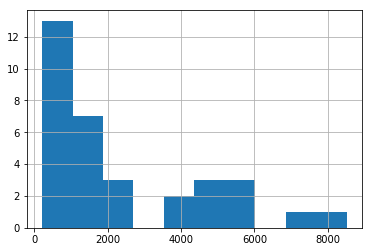

In [183]:
location_unigram_df['Count'].hist()

In [189]:
len(listings_df2)

78358

In [172]:
# Get location coefficents and number of listings

location_list = list(X_test_unigram_df.columns)[-33:]
location_coefficients = unigram_location_coef[-33:]
location_unigram_df = pd.DataFrame(index = location_list,columns = ['Coefficient'],data = location_coefficients)
location_count = listings_df2.groupby('neighbourhood_cleansed').count()['name']
location_unigram_df = location_unigram_df.join(location_count)
location_unigram_df = location_unigram_df.rename(columns = {'Coefficient': 'Coefficient','name':'Count'}) 
location_unigram_df = location_unigram_df.sort_values('Coefficient',ascending = False)
location_unigram_df.to_csv('location_coefficients.csv')
location_unigram_df

,Coefficient,Count
Kensington and Chelsea,0.621563,5590
City of London,0.574488,426
Westminster,0.567320,8506
Camden,0.406970,5535
Hammersmith and Fulham,0.256824,3956
Islington,0.253530,4806
Richmond upon Thames,0.238310,1146
Wandsworth,0.188608,3974
Southwark,0.171410,4647
Lambeth,0.127622,4624


In [186]:
location_unigram_df['Count'].describe()

count      33.000000
mean     2374.484848
std      2317.759628
min       221.000000
25%       560.000000
50%      1437.000000
75%      3974.000000
max      8506.000000
Name: Count, dtype: float64

In [185]:
location_unigram_df['Count'].median()

1437.0

In [75]:
# most informative 100

least_idx_unigram_location = np.argsort(unigram_location_coef)[:100]
most_idx_unigram_location = np.argsort(unigram_location_coef)[-100:]

In [76]:
# get the least informative parameters

least_parameter_location_unigram = []
for idx in least_idx_unigram_location:
    least_parameter_location_unigram.append(list(X_train_unigram_df.columns)[idx])

In [77]:
# get the most informative parameters

most_parameter_location_unigram = []
for idx in most_idx_unigram_location:
    most_parameter_location_unigram.append(list(X_train_unigram_df.columns)[idx])

In [79]:
# Get the coefficients of the parameters

least_unigram_coefficients_location = []
for idx in least_idx_unigram_location:
    least_unigram_coefficients_location.append(unigram_location_coef[idx])
    
most_unigram_coefficients_location = []
for idx in most_idx_unigram_location:
    most_unigram_coefficients_location.append(unigram_location_coef[idx])

In [80]:
least_unigram_location_df = pd.DataFrame(index = least_parameter_location_unigram,columns = ['Coefficient'],data = least_unigram_coefficients_location)

In [162]:
least_unigram_location_df.to_csv('least_impactful.csv')
least_unigram_location_df

,Coefficient
dorm,-1.200811
dormitory,-0.630260
britannia,-0.559522
room,-0.479731
share,-0.422131
single,-0.327315
chambre,-0.302609
doubleroom,-0.297404
bedroom,-0.256911
small,-0.250082


In [83]:
most_unigram_location_df = pd.DataFrame(index = most_parameter_location_unigram,columns = ['Coefficient'],data = most_unigram_coefficients_location)

In [161]:
most_unigram_location_df = most_unigram_location_df.sort_values('Coefficient',ascending= False)
most_unigram_location_df.to_csv('most_impactful.csv')
most_unigram_location_df

,Coefficient
onefinestay,1.578568
five,0.978494
six,0.878236
four,0.824256
three,0.641803
Kensington and Chelsea,0.621563
City of London,0.574488
Westminster,0.567320
olympics,0.544742
superior,0.532859


## Unigram, Bigram, and Trigram

In [91]:
# Create one-hot-encoded df for all bigrams
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

lasso_bigram_df = pd.DataFrame(mlb.fit_transform(listings_df2['bigrams']),columns=mlb.classes_, index=listings_df2.index)
lasso_bigram_df.head()

,"(, )","(, 02)","(, 1)","(, 10)","(, 1000sq)","(, 100mb)","(, 104)","(, 11min)","(, 12)","(, 14)",...,"(럭셔리, 아파트)","(로맨틱, 2인용)","(배스룸키친, 쉐어)","(빅토리안, 하우스)","(엄청, 넓은)","(욕실, 화장실)","(편리한, 럭셔리)","(하우스, 엄청)","(화장실, 깨끗하고)","(️️️️️, one)"
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [98]:
# pickle the df
filename = 'lasso_bigram_df'
outfile = open(filename,'wb')
pickle.dump(lasso_bigram_df.iloc[:100,:],outfile,protocol=4)
outfile.close()

In [ ]:
lasso_bigram_df['log_price'] = [np.log(price) for price in listings_df2['price']]

In [94]:
# Create one-hot-encoded df for all trigrams
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

lasso_trigram_df = pd.DataFrame(mlb.fit_transform(listings_df2['trigrams']),columns=mlb.classes_, index=listings_df2.index)
lasso_trigram_df.head()

,"(, , )","(, , 1)","(, , 6)","(, , 6th)","(, , at)","(, , bath★)","(, , bedroom)","(, , brick)","(, , can)","(, , central)",...,"(넓은, 로맨틱, 2인용)","(다락방단독, 배스룸키친, 쉐어)","(로맨틱, 2인용, 다락방단독)","(빅토리안, 하우스, 엄청)","(엄청, 넓은, 로맨틱)","(욕실, 화장실, 깨끗하고)","(편리한, 럭셔리, 아파트)","(하우스, 엄청, 넓은)","(화장실, 깨끗하고, 교통)","(️️️️️, one, bed)"
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [97]:
# pickle the df
filename = 'lasso_trigram_df'
outfile = open(filename,'wb')
pickle.dump(lasso_trigram_df.iloc[:100,:],outfile,protocol=4)
outfile.close()

In [ ]:
np.concatenate((lasso_unigram.values,lasso_bigram_df.values),axis=1)

In [ ]:
lasso_ngrams_df = lasso_unigram.merge(lasso_bigram_df,left_index = True, right_index = True) 

In [ ]:
print(len(lasso_bigram_df.columsn),len(lasso_unigram.columns),len(lasso_ngrams_df))